### Scraping Complaints

In [1]:
import requests, json
from bs4 import BeautifulSoup
from datetime import datetime

def scrape_website(url):
    response = requests.get(url)
    
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        return soup
    else:
        raise RuntimeError(f'Scraper failed! Recieved: {response}')

complaint_id = 108215
url = f"https://cts.gaepd.org/Public/ComplaintDetails/{complaint_id}"
soup = scrape_website(url)

In [2]:
COMPLAINT_ID = "complaint"
LOCATION_STRING = "Location of Complaint"
RECV_STRING = "Date Received"
SOURCE_NAME_STRING = "Source Name"
SOURCE_ADDRESS_STRING = "Source Address"

def get_complaint(soup):
    elem = soup.find(id=COMPLAINT_ID)
    if elem:
        elem = elem.find_next_sibling('p')
        if elem: return elem.get_text()
    return None
    
def get_tabe_element(soup, string):
    elem = soup.find('th', string=string)    
    if elem:
        elem = elem.find_next('td')
        if elem: return elem.get_text(strip=True)
    return None

def get_location(soup):
    return get_tabe_element(soup, string=LOCATION_STRING)

def get_date_received(soup):
    date = get_tabe_element(soup, string=RECV_STRING)
    return datetime.strptime(date, '%B %d, %Y, %I:%M %p').strftime("%Y-%m-%d %H:%M:%S")

def get_source_name(soup):
    return get_tabe_element(soup, string=SOURCE_NAME_STRING)

def get_source_location(soup):
    return get_tabe_element(soup, string=SOURCE_ADDRESS_STRING)

In [3]:
entry = {}

entry['complaint'] = get_complaint(soup)
entry['location'] = get_location(soup)
entry['date_received'] = get_date_received(soup)
entry['source_name'] = get_source_name(soup)
entry['source_location'] = get_source_location(soup)

entry

{'complaint': 'Burning for about 3 months since they came in, and they have been 2-3 times day. \r\n\r\nSmoke has been causing problems for most neighbors. \r\n\r\nComplainant says that they are burning work materials. ',
 'location': '2554 Hightower Ct Atlanta\r\n\r\nOnly house made of Siding/ off white dark trim with deep brown and dark grey tones. Torn Blinds- makeshift wire going through sticks of wire across the front of the house. \r\nTwo white Vans with company names and trailer that is always in front yard. Work tools/material under porch. There is another vehicle described as the Nissan Sentra.',
 'date_received': datetime.datetime(2024, 3, 18, 12, 0),
 'source_name': 'Comfort Kings Heating and Air',
 'source_location': 'Atlanta, Georgia'}

In [4]:
def get_href_suffixes(soup, prefix):
    return [l['href'].replace(prefix, '') for l in soup.find_all('a') if l.get('href', '').startswith(prefix)]


def get_complaint_ids(date_from, date_to):
    complaint_ids, n = [], 1
    while True:
        print(f'Looking for complaints on page {n}...')
        url = f'https://cts.gaepd.org/Public?submit=Page&page={n}&sort=IdDesc&DateFrom={date_from}&DateTo={date_to}&TypeId=800670b6-2ae3-49e0-afef-37156006bf1f#search-results'
        soup = scrape_website(url)
        ids = get_href_suffixes(soup, '/Public/ComplaintDetails/')
        if len(ids) > 0:
            complaint_ids += ids
            n += 1
        else:
            break
    return complaint_ids


complaint_ids = get_complaint_ids('1-1-2024', '4-1-2024')

Looking for complaints on page 1...
Looking for complaints on page 2...
Looking for complaints on page 3...
Looking for complaints on page 4...
Looking for complaints on page 5...
Looking for complaints on page 6...


In [5]:
def scrape_complaint(complaint_id):
    url = f"https://cts.gaepd.org/Public/ComplaintDetails/{complaint_id}"
    soup = scrape_website(url)

    entry = {}
    entry['_id'] = complaint_id
    entry['complaint'] = get_complaint(soup)
    entry['location'] = get_location(soup)
    entry['date_received'] = get_date_received(soup)
    entry['source_name'] = get_source_name(soup)
    entry['source_location'] = get_source_location(soup)
    return entry


data = []
for _id in complaint_ids:
    print(f'Scraping complaint id {_id}...')
    data += [scrape_complaint(_id)]

Scraping complaint id 108308...
Scraping complaint id 108293...
Scraping complaint id 108255...
Scraping complaint id 108243...
Scraping complaint id 108241...
Scraping complaint id 108215...
Scraping complaint id 108205...
Scraping complaint id 108197...
Scraping complaint id 108192...
Scraping complaint id 108127...
Scraping complaint id 108126...
Scraping complaint id 108104...
Scraping complaint id 108076...
Scraping complaint id 108039...
Scraping complaint id 108014...
Scraping complaint id 107993...
Scraping complaint id 107965...
Scraping complaint id 107949...
Scraping complaint id 107940...
Scraping complaint id 107931...
Scraping complaint id 107930...
Scraping complaint id 107925...
Scraping complaint id 107920...
Scraping complaint id 107916...
Scraping complaint id 107906...
Scraping complaint id 107905...
Scraping complaint id 107883...
Scraping complaint id 107881...
Scraping complaint id 107877...
Scraping complaint id 107874...
Scraping complaint id 107870...
Scraping

In [10]:
import json

OUTPUT_PATH = 'complaints.json'

with open(OUTPUT_PATH, 'w') as f:
    json.dump(data, f, indent=4)

### Processing Complaints

In [1]:
import json

OUTPUT_PATH = 'complaints.json'

with open(OUTPUT_PATH, 'r', encoding='utf-8') as f:
    complaints = json.load(f)

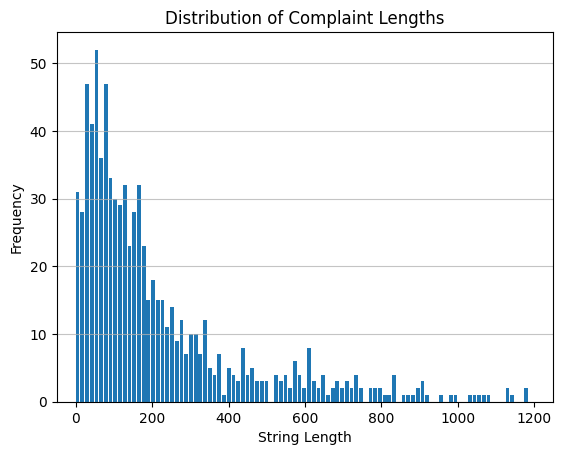

In [2]:
import matplotlib.pyplot as plt

strings = [len(c['complaint']) for c in complaints]

plt.hist(strings, bins=1000, align='left', rwidth=0.8)
plt.xlabel('String Length')
plt.ylabel('Frequency')
plt.title('Distribution of Complaint Lengths')
plt.xlim(-50, 1250)
plt.grid(axis='y', alpha=0.75)

plt.show()

In [3]:
len(complaints)

836

In [5]:
keywords = ['burn', 'Not entered', 'caller', 'email@removed.invalid']
filtered = [c for c in complaints if not any(k.lower() in c['complaint'].lower() for k in keywords)]
# filtered = list(set([c['complaint'] for c in filtered]))
print(len(filtered))

# FILTER COMPLAINTS
complaints = [c for c in complaints if not any(k.lower() in c['complaint'].lower() for k in keywords)]

836


In [7]:
from datetime import datetime

def average_entries_per_week(datetimes):
    datetimes.sort()
    num_weeks = ((datetimes[-1] - datetimes[0]).days + 1) / 7    
    return len(datetimes) / num_weeks

datetimes = [datetime.strptime(c['date_received'], '%Y-%m-%d %H:%M:%S') for c in complaints]
average_per_week = average_entries_per_week(datetimes)
print(f"Average entries per week: {average_per_week:.2f}")


Average entries per week: 3.81


In [6]:
"""
Idea! Perform classification tasks in 5 categories corresponding to "features" of the complaint.

Then, the probability of deploying the van is a function of each category classification

Finally, this can be packaged and deployed on a bootstrap interface
"""

'\nIdea! Perform classification tasks in 5 categories corresponding to "features" of the complaint.\n\nThen, the probability of deploying the van is a function of each category classification\n\nFinally, this can be packaged and deployed on a bootstrap interface\n'

In [6]:
CATEGORIES = {
    'pollutor': "- Look for mentions of a pollutor. This contains mentions of 'plant', 'factory', 'air quality'",
    'odor': "- Look for mentions of smells or odors of a pollutant. This contains mentions of 'smell', 'odor'",
    'aqi': "- Look for specific mentions of air and inhalation. This contains mentions of 'fumes', 'ventilation'",
    'source': "- Look for descriptions of types or identifications of pollutors. This contains mentions of a SOURCE or SPECIFIC TYPE of a pollutant (such as 'benzene')",
    'health': "- Look for complaints of an individual's physical health. This contains physical problems, such as a patient 'hurt' or 'burning' from pollution"
}

PROMPT = """
Given a categorization, return whether the COMPLAINT mentions the CATEGORY on a scale of 1-3.

SCALE:
- 1: No mention of the problem, this should be ignored
- 2: Vaguely mentions the problem, but it should be followed up with a message
- 3: This problem is fully described and looked into

CATEGORY:
{category}

COMPLAINT:
{complaint}

Only respond with a number (1 or 2 or 3)

Categorization:"""

In [9]:
from tqdm import tqdm
from openai import OpenAI

with open('/Users/dhei/.OPENAI-SECRET', 'r') as f: 
    api_key = f.read().strip()

client = OpenAI(api_key=api_key)

max_tokens = 1

def gpt_generate(prompt):
  out = client.chat.completions.create(
      model="gpt-3.5-turbo-0125",
      messages=[{"role": "user", "content": prompt}],
      top_p = 1,
      temperature = 0,
      max_tokens = max_tokens
  )
  return out.choices[0].message.content

In [14]:
for i in tqdm(range(len(complaints))):
    if 'answers' in complaints[i].keys():
        continue

    answers = {}
    for cat in list(CATEGORIES.keys()):
        out = gpt_generate(PROMPT.format(category=CATEGORIES[cat], complaint=complaints[i]['complaint']))
        try:
            out = int(out)
        except ValueError:
            out = 0
        answers[cat] = out

    complaints[i]['answers'] = answers

100%|██████████| 836/836 [19:10<00:00,  1.38s/it]


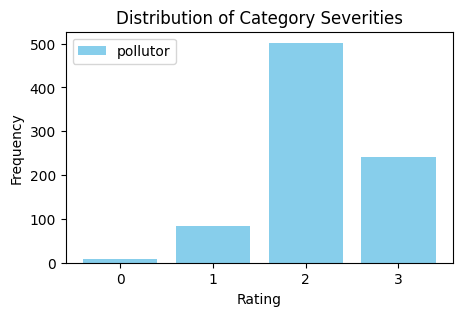

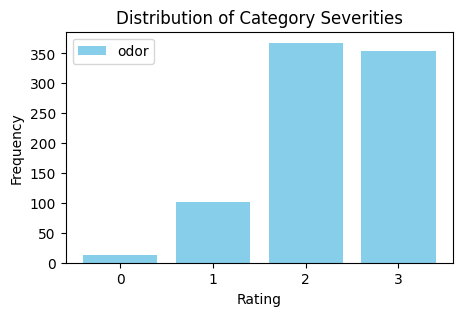

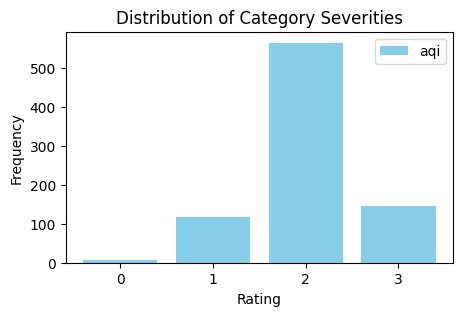

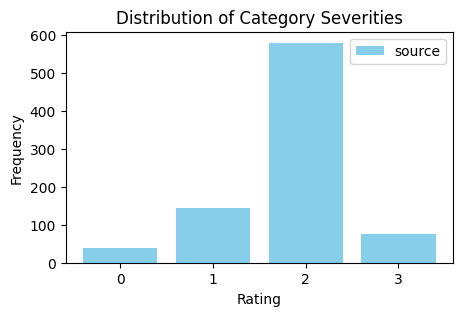

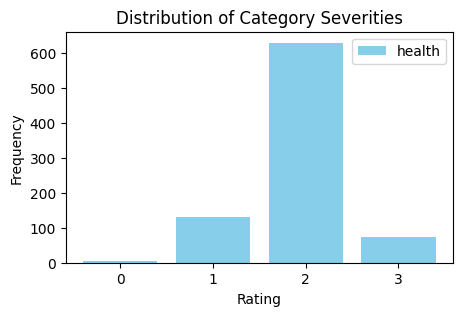

In [7]:
from collections import Counter

for cat in list(CATEGORIES.keys()):
    vals = [e['answers'][cat] for e in complaints if 'answers' in e.keys()]

    plt.figure(figsize=(5, 3))
    
    counts = dict(Counter(vals))
    plt.bar(counts.keys(), counts.values(), color='skyblue', label=cat)

    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.title('Distribution of Category Severities')
    plt.xticks(range(0, max(counts.keys())+1))
    plt.legend()
    plt.show()

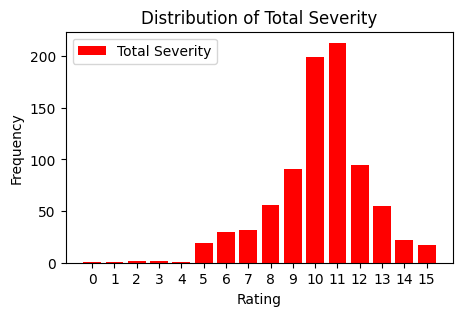

In [8]:
vals = [sum(e['answers'].values()) for e in complaints if 'answers' in e.keys()]

plt.figure(figsize=(5, 3))

counts = dict(Counter(vals))
plt.bar(counts.keys(), counts.values(), color='red', label='Total Severity')

plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Total Severity')
plt.xticks(range(0, max(counts.keys())+1))
plt.legend()
plt.show()

In [17]:
import json

OUTPUT_PATH = 'complaints.json'

with open(OUTPUT_PATH, 'w') as f:
    json.dump(complaints, f, indent=4)